In [1]:
!pip3 install pyro-ppl 

     |████████████████████████████████| 614kB 5.5MB/s 


tensor(3.0214)


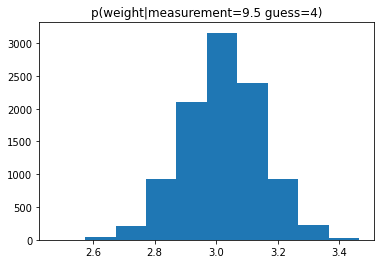

In [56]:
"""
Intro to Probabilistic Programming: Models and Inference in Pyro
by Sourabh Kulkarni (https://www.github.com/SourabhKul)
Following instructions from MLTrain@UAI 2018 Pyro Workshop
Some basics before we get started:
Why Probabilistic Programming? Powerful generative models:
- Character Generation 
- Scene Representation
- Physics Engines: Simulating real worlds
- Automated Statistician: Perform statistical analysis automatically
Principles of Probabilistic Inference:
- Sum Rule: P(x) = sum_y(P(x,y))
- Product Rule = P(x,y) = P(x)p(y|x)
- Bayes Rule = P(theta|data) = P(data|theta)P(theta)/P(data)
Some Terminology:
- P(theta|data) is the posterior of theta given data
- P(data|theta) is the likelihood of theta
- P(theta) is the prior over theta
Probabilistic Programming Languages:
- Uniform, Universal specification of processes with high-level abstractions
Recipe:
- High-level Programming Language (python)
- Primitives of random objects as probability distributions (random/stochastic functions)
- Sampling Statements (draw samples from random functions)
- Perform Inference (computing posterior)
Let's get started!
"""
import numpy as np
import torch
import pyro as py
import pyro.distributions as dist
import pyro.infer
import pyro.optim

import matplotlib.pyplot as plt 

"""
Models in Pyro
"""

def weather(p_cloudy):
    """
    This is an example of a stochastic function. It predicts the weather given the probability of it being cloudy
    input:
        - p_cloudy(float): probability that it is cloudy outside
    returns:
        - is_cloudy(boolean): is it cloudy?
        - tempreature(float): a sample from the distribution of weather given is_cloudy
    """
    is_cloudy = dist.Bernoulli(p_cloudy).sample()
    
    if is_cloudy:
        loc, scale = 55.0, 10.0
    else:
        loc, scale = 75.0, 15.0
    
    temperature = py.sample("temp", dist.Normal(loc,scale))

    return is_cloudy.item(), temperature.item()

def ice_cream_sales():
    """
    Another stochastic function that estimates ice cream sales based on weather
    inputs:
        - none
    returns:
        - sample from the distibution of expected sales
    """
    is_cloudy, temperature = weather(0.3)

    if not is_cloudy and temperature >= 80:
        expected_sales = 200
    else:
        expected_sales = 50
    
    return py.sample('sales', dist.Normal(expected_sales,10))

# print (ice_cream_sales())

"""
Inference in Pyro
"""


def scale(guess):
    """
    In this stochastic function, we have an initial guess of the weight and we assume
    the true weight is a gaussian with mean value of the guess and sigma of 1. We then
    model the noisy scale with a gaussian with mean as the true weight and variance of
    0.85 and return a sample from that distribution
    inputs:
        - guess: initial guess of the weight
    returns:
        - measurement: the weight as measured by the noisy scale 
    """
    weight = py.sample("weight", dist.Normal(guess,1))
    py.sample("measurement", dist.Normal(weight,0.75))
    py.sample("measurement2", dist.Normal(weight**2,0.75))

def guide(guess):
    """
    In this stochastic function, we have an initial guess of the weight and we assume
    the true weight is a gaussian with mean value of the guess and sigma of 1. We then
    model the noisy scale with a gaussian with mean as the true weight and variance of
    0.85 and return a sample from that distribution
    inputs:
        - guess: initial guess of the weight
    returns:
        - measurement: the weight as measured by the noisy scale 
    """
    weight = py.sample("weight", dist.Normal(guess,1))

# We can condition the scale function by the observed measurement as follows
observed_measurement = 9.5
observed_measurement2 = 9.1
conditioned_scale = py.condition(scale, data={"measurement":observed_measurement})
conditioned_scale = py.condition(scale, data={"measurement2":observed_measurement2})

# We can now infer over the posterior of the function given the observed measurement
posterior = py.infer.Importance(conditioned_scale, guide, num_samples=10000)

guess = 4
marginal = py.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")
print(marginal.mean)

plt.hist(np.array(marginal.sample((10000,))))
plt.title("p(weight|measurement="+str(observed_measurement)+" guess="+str(guess)+")")
plt.show()

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:53: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  'samples from the posterior.', FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


a= 3.118690013885498
b= 0.12759342789649963


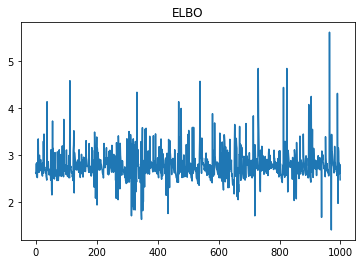

3.225494146347046


In [ ]:
"""
Stochastic Variational Inference in Pyro
For SVI, we develop a guide fucnction which has some parameters specified.
We then optimize these parameters using pytorch's optimization methods
"""

def parameterized_guide(guess):
    """
    This guide assumes a gaussian posterior and defines parameters to be learnt for the same.
    Note that the sample 'name' is same as the name of the weight variable from the earlier 
    function. This is because we are optmimizing w.r.t that variable. Also note that it is 
    an unconstrained variable, i.e., not evidenced upon (we cannot 'know' a weight a priori,
    as we are trying to measure it in the first place)
    inputs:
        - guess: your guess of what the weight could be
    returns:
        - a sample of 'weight' from the gaussian distribution parameterized by this function
    """
    a = py.param("a", torch.tensor(torch.randn(1)+guess))
    b = py.param("b", torch.randn(1))

    return py.sample("weight", dist.Normal(a,torch.abs(b)))

# Now we start the optmimization process using a svi wrapper. This is a pyro wrapper for invoking
# Pytorch's own optmimizer

svi = py.infer.SVI(model=conditioned_scale, guide=parameterized_guide,optim=py.optim.SGD({'lr' : 0.001}),loss=py.infer.Trace_ELBO(), num_samples=1000)

# We now run this optmization for 1000 steps, observe loss and print out the learnt parameters
losses, a, b = [], [], []

for t in range(1000):
    losses.append(svi.step(guess))
    a.append(py.param("a").item())
    b.append(py.param("b").item())

plt.plot(losses)
plt.title("ELBO")
print ("a=",pyro.param('a').item())
print ("b=",pyro.param('b').item())
plt.show()

# We can now sample from the parameterized_guide function as a posterior

print (parameterized_guide(8).item())